This colab is suggested to run on a remote Google Cloud machine. For more instructions on setting up the colab interface for google cloud, please refer to the beginning of ProcessingDigitalGlobeTifData https://colab.research.google.com/drive/18EE-_HZWaXOXniI-CBGVAnz3XgKL6vOD

In [1]:
# Install necessary imports for converting to TF Record. Note that these
# commands may have to be run on the VM itself because they ask for confirmation
# !conda install -c conda-forge tensorflow contextlib2 matplotlib
# !conda create --name cs325b
# !source activate cs325b

# Import necessary libraries
import numpy as np
import os
import pandas as pd
from PIL import Image
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import random
import itertools
import contextlib2
from collections import Counter, defaultdict
import tensorflow as tf

/home/mekmarriott/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 2. Converting Data to TF Records

In [0]:
# Just a few of the parameters we used for generating the tfrecord datasets. For
# the train, validation, and test splits we performed these on the camp level.
# However, the fractions themselves correspond to examples. Since each camp has
# variable numbers of examples we provided a buffer amount to guarantee a
# a certain range of percentage for the camp splits.
# Note that REGION is empty here but populated when we actually run the code for
# each region

REGION = ''
DIRECTORY = 'satellite'
OUTPUT_DIR = 'tf_records_100_label'
TEST_FRAC = 0.15
VALIDATION_FRAC = 0.15
BUFFER_FRAC = 0.05

In [0]:
# Note that since we have a mounted file system, we will need to create
# directories ahead of time to store our tfrecord files. Here, we use the
# folder tf_records_100 to store our 100 x 100 small crops
# Uncomment below to create the corresponding directories

!mkdir satellite/tf_records_100
!mkdir satellite/tf_records_100/Africa1
!mkdir satellite/tf_records_100/Africa2
!mkdir satellite/tf_records_100/WesternAsia

## Training Labels

In [0]:
import json
from collections import defaultdict
from collections import Counter

In [0]:
# This is the directory of the mounted google bucket
GOOGLE_BUCKET_DIR = 'satellite/'

# NOTE: I added 'labels' directory before each file now that it is local
# and we are storing the geojson rating data here
REGION_MAPPINGS = {
    'Africa1': {
        'qc': GOOGLE_BUCKET_DIR + 'labels/africa1_qcexport_20180906.geojson',
        'raw': GOOGLE_BUCKET_DIR + 'labels/africa1_rawtags_20180906.geojson'},
    'Africa2': {
        'qc': GOOGLE_BUCKET_DIR + 'labels/africa2_qcexport_20180927.geojson',
        'raw': GOOGLE_BUCKET_DIR + 'labels/africa2_rawtags_20180927.geojson'},
    'Bangladesh': {
        'qc': GOOGLE_BUCKET_DIR + 'labels/bangladesh_qcexport_20180906.geojson',
        'raw': GOOGLE_BUCKET_DIR + 'labels/bangladesh_rawtags_20180906.geojson'},
    'WesternAsia': {
        'qc': GOOGLE_BUCKET_DIR + 'labels/westernAsia_qcexport_20180906.geojson',
        'raw': GOOGLE_BUCKET_DIR + 'labels/westernAsia_rawtags_20180906.geojson'}
}

In [0]:
# Featurize datasets (QC and Raw) according to the following schema from the
# stored json object. Note that we:
#   1) Ignore the metadata tags and only use the 'feature tag'
#   2) Expand the geography tag within the feature tag to 'latitude',
#      'longitude', and 'coordinate_type' keys, in addition to the raw geojson
#   3) Convert date features to pandas Timestamp and confidence score to float
#
# QC datasets
# id: unique identifier
# label: name for the feature type
# score: the CrowdRank confidence score of the assigned attribute, relative to other tags in the dataset. (floating point 0-1 with 0=no confidence, 1= fully confident)
# agreement: number of other taggers who placed the same tag type on this point
# chip_url: link to a .jpg image chip hosted on aws with the identified feature in the center of the image
# timestamp: Date/time in GMT of the last QC batch
# acquisition_date: Date the image was collected
# sensor: the DigitalGlobe satellite that captured the image
# catalog_id: DigitalGlobe identifier for the image strips collected by our satellites
# map_id: unique identifier for each lattice cell across the imagery
#
# Raw tags
# id: unique identifier
# tagger_id: unique identifier of the user
# map_view_id: not too helpful for you, but I can use this to link back to another table in the database for the map/image seen by the crowd
# type_id: database tag for the feature type
# label: name for the feature type
# timestamp: time in GMT that tag was placed

CHIP_URL_PREFIX = 'https://s3.amazonaws.com/explorationlab/chips/'

def get_features(filepath, region):
  with open(filepath) as f:
    content = f.read()
  obj = json.loads(content)
  data = defaultdict(list)
  for x in obj['features']:
    data['latitude'].append(x['geometry']['coordinates'][1])
    data['longitude'].append(x['geometry']['coordinates'][0])
    data['coordinate_type'].append(x['geometry']['type'])
    for key in x['properties'].keys():
      if key == 'acquisition_date' or key == 'timestamp':
        data[key].append(pd.Timestamp(x['properties'][key]))
      elif key == 'score':
        data[key].append(float(x['properties'][key]))
      elif key == 'chip_url':
        data[key].append(x['properties'][key].replace(CHIP_URL_PREFIX, ''))
      else:
        data[key].append(x['properties'][key])
  df = pd.DataFrame.from_dict(dict(data))
  df['region'] = region
  # Clean data a little - group all 'Other Tent ...' together in an 'Other' category
  df['label'] = df['label'].apply(lambda x: 'Other Tent' if x.startswith('Other Tent') else x)
  return df

In [0]:
# Create the labels from the CSV raters file for each region and combine them
# in to a single pandas dataframe
qc = pd.DataFrame()
for region in REGION_MAPPINGS.keys():
  if len(qc) == 0:
    qc = get_features(REGION_MAPPINGS[region]['qc'], region)
  else:
    qc = qc.append(get_features(REGION_MAPPINGS[region]['qc'], region))

In [7]:
qc[qc.chip_url == 'a7ec1951fa272fcd80234279112c9c2a.jpg']

,acquisition_date,agreement,catalog_id,chip_url,coordinate_type,id,label,latitude,longitude,map_id,score,sensor,timestamp,region
17207,2017-11-13 14:53:33.372000+00:00,2,10300100745B4800,a7ec1951fa272fcd80234279112c9c2a.jpg,Point,358216-69040,Administrative Structure,36.469313,43.893755,28955,0.517609,WV02,2018-07-07 02:02:17.988000+00:00,WesternAsia


## Methods

In [0]:
# These helper methods are adapted from dataset_utils in the tfrecords directory
# https://github.com/tensorflow/models/blob/master/research/object_detection/utils/dataset_util.py

def float_feature(value):
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def int64_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def int64_list_feature(value):
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def bytes_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def bytes_list_feature(value):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))

In [0]:
# For reference on this conversion function, go to
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md

LABELS = {b'UNHCR Tent' : 1,
          b'Administrative Structure': 2,
          b'Round Earthen Structure': 3,
          b'Other Tent' : 4} #Africa1 + Africa2

def zero_to_one(data_list):
  """
  Clip values from 0 to 1 for a list of floats
  """
  return [min(max(a, 0), 1) for a in data_list]

def create_tf_record(img_filename, labels, shard_sz=0, show=False,
                     bbox_size=40):
  """
  Create TF Records from an image filename and labels
  img_filename: path to the .png file
  labels: The pandas dataframe of labels for structures in this image
  shard_sz: If defined, is the size of the output example images in the tfrecord
            If not defined, each example will default to its original
            image size
  show: Whether to show a visualization of the example output(s) with structures
  bbox_size: Width of the bounding box around each label. Defaults to 40
  """
  try:
    im = Image.open(img_filename)
  except:
    print("Could not open file %s. Skipping ..." % img_filename)
    return

  width, height = im.size
  im = np.array(im)
 
  encoded_image_data = open(img_filename, 'rb').read() # Encoded image bytes
  image_format = b'str'

  # List of normalized left x coordinates in bounding box (1 per box)
  xmins = zero_to_one(list((labels.x - bbox_size/2)/width))
  # List of normalized right x coordinates in bounding box (1 per box)
  xmaxs = zero_to_one(list((labels.x + bbox_size/2)/width))
  # List of normalized top y coordinates in bounding box (1 per box)
  ymins = zero_to_one(list((labels.y - bbox_size/2)/height))
  # List of normalized bottom y coordinates in bounding box (1 per box)
  ymaxs = zero_to_one(list((labels.y + bbox_size/2)/height))
  
  # Get all x/y for each box corner
  x_c = [int(x*width) for x in xmins + xmins + xmaxs + xmaxs]
  y_c = [int(y*height) for y in ymins + ymaxs + ymins + ymaxs]
  
  # Get all x/y for each point
  x_labels = list(labels.x)
  y_labels = list(labels.y)
  
  # Get all class labels
  c_labels = list(labels.label)
  
  # Get lat/lon of the original image
  start_lat = list(labels.min_lat)[0]
  start_lon = list(labels.min_lon)[0]
  end_lat = list(labels.max_lat)[0]
  end_lon = list(labels.max_lon)[0]

  if shard_sz > 0:
    shard_x = shard_sz
    shard_y = shard_sz
  else:
    shard_x = width
    shard_y = height

  num_cols = int(width/shard_x)
  num_rows = int(height/shard_y)
  lat_width = float(end_lat - start_lat)/num_cols
  lon_width = float(end_lon - start_lon)/num_rows

  # If the shard size is defined, create outputs tiling the entire image with
  # shard_sz width/height
  if shard_sz > 0:
    shards = [im[i*shard_x:(i+1)*shard_x, j*shard_y:(j+1)*shard_y
                ] for i in range(num_rows) for j in range(num_cols)]
  else:
    shards = [im]

  corners_x = defaultdict(list)
  corners_y = defaultdict(list)
  points_x = defaultdict(list)
  points_y = defaultdict(list)
  classes_text = defaultdict(list)
  
  # Assign points/classes for each grid output
  for i in range(len(x_labels)):
    points_x[int(x_labels[i]/shard_x) + int(
        y_labels[i]/shard_y)*num_rows].append(int(x_labels[i]) % shard_x)
    points_y[int(x_labels[i]/shard_x) + int(
        y_labels[i]/shard_y)*num_rows].append(int(y_labels[i]) % shard_y)
    classes_text[int(x_labels[i]/shard_x) + int(
        y_labels[i]/shard_y)*num_rows].append(c_labels[i])
  for i in range(len(x_c)):
    corners_x[int(x_c[i]/shard_x) + int(
        y_c[i]/shard_y)*num_rows].append(x_c[i] % shard_x)
    corners_y[int(x_c[i]/shard_x) + int(
        y_c[i]/shard_y)*num_rows].append(y_c[i] % shard_y)

  tf_examples = []
  if show:
    fig=plt.figure(figsize=(num_cols*(12/num_cols), num_rows*(12/num_rows)))
    
  color_mappings = {
      'UNHCR Tent': 'green',
      'Administrative Structure': 'red',
      'Other Tent': 'yellow',
      'Round Earthen Structure': 'gray'
  }
  
  # Assign structure labels for each grid output
  for i in range(len(shards)):
    row_num, col_num = i%num_rows, i/num_rows
    min_lat = start_lat+row_num*lat_width
    min_lon = start_lon+col_num*lon_width
    max_lat = start_lat+(row_num+1)*lat_width
    max_lon = start_lon+(col_num+1)*lon_width
    
    if show:
      ax = fig.add_subplot(num_cols, num_rows, i+1)
      ax.imshow(shards[i])
      for j in range(len(corners_x[i])):
        ax.add_patch(Rectangle((corners_x[i][j]-1, corners_y[i][j]-1), 2, 2,
                               facecolor='none', edgecolor='red', linewidth=2))
      for j in range(len(points_x[i])):
        ax.add_patch(Rectangle((points_x[i][j]-bbox_size/2,
                                points_y[i][j]-bbox_size/2),
                               bbox_size, bbox_size,
                               facecolor='none',
                               edgecolor=color_mappings[classes_text[i][j]],
                               linewidth=2))
      ax.set_xlabel("%0.6f - %0.6f lat" % (min_lat, max_lat))
      ax.set_ylabel("%0.6f - %0.6f lon" % (min_lon, max_lon))

    # Add the respective TF Example to the list
    tf_examples.append(
      tf.train.Example(features=tf.train.Features(
        feature={
          'image/height': int64_feature(height),
          'image/width': int64_feature(width),
          'image/filename': bytes_feature(img_filename.encode()),
          'image/encoded': bytes_feature(shards[i].tostring()),
          'image/format': bytes_feature(image_format),
          'image/object/corners/x': int64_list_feature(corners_x[i]),
          'image/object/corners/y': int64_list_feature(corners_y[i]),
          'image/object/point/x': int64_list_feature(points_x[i]),
          'image/object/point/y': int64_list_feature(points_y[i]),
          'image/object/class/text': bytes_list_feature([
              x.encode() for x in classes_text[i]]),
          'image/object/min_lat': float_feature(min_lat),
          'image/object/min_lon': float_feature(min_lon),
          'image/object/max_lat': float_feature(max_lat),
          'image/object/max_lon': float_feature(max_lon),
        }
      )
    ))
  plt.show()
    
  return tf_examples

In [0]:
# Note that the function below is taken from:
# https://github.com/tensorflow/models/blob/master/research/object_detection/dataset_tools/tf_record_creation_util.py)

def open_sharded_output_tfrecords(exit_stack, base_path, num_shards):
  """Opens all TFRecord shards for writing and adds them to an exit stack.
  Args:
    exit_stack: A context2.ExitStack used to automatically closed the TFRecords
      opened in this function.
    base_path: The base path for all shards
    num_shards: The number of shards
  Returns:
    The list of opened TFRecords. Position k in the list corresponds to shard k.
  """
  tf_record_output_filenames = [
      '{}-{:05d}-of-{:05d}'.format(base_path, idx, num_shards)
      for idx in range(num_shards)
  ]

  tfrecords = [
      exit_stack.enter_context(tf.python_io.TFRecordWriter(file_name))
      for file_name in tf_record_output_filenames
  ]

  return tfrecords

In [0]:
def create_tf_record_set(set_type, crops, label_df, region, output_dir='tf_records',
                         shard_sz=0, num_shards=10, bbox_size=40):
  """
  Outputs tf records based from the image filenames and corresponding labels
  set_type: one of (train, val, test) which identifies the type of tfrecord data
  crops: the list of image filenames to process
  label_df: the aggregated pandas dataframe of the structures and their data
  region: the string region for the tfrecord
  output_dir: the folder where the tfrecords should be created in
  shard_sz: see create_tf_record
  num_shards: the number of files the output should be sharded to, default is 10
  bbox_size: see create_tf_record
  """
  output_filebase = '%s/%s/%s/%s.tfrecord' % (DIRECTORY, output_dir, region, set_type)
  print('Outputting to ', output_filebase)
  with contextlib2.ExitStack() as tf_record_close_stack:
    output_tfrecords = open_sharded_output_tfrecords(
        tf_record_close_stack, output_filebase, num_shards)
    for i in range(len(crops)):
      try:
        tf_examples = create_tf_record(
            '%s/%s/%s.png' % (DIRECTORY, region, crops[i]),
            label_df[label_df.crop_id == crops[i]], bbox_size=bbox_size,
            shard_sz=shard_sz)
        output_shard_index = i % num_shards
        for tf_example in tf_examples:
          output_tfrecords[output_shard_index].write(tf_example.SerializeToString())
        if i % 100 == 0:
          print('Completed', i, '/', len(crops), 'in', set_type, 'set')
      except:
        print('Could not complete example for crop id %s, continuing...' % crops[i])
        continue

In [0]:
def stratified_random_sample(arr, target, buffer, strata_dict):
  """
  Creates a stratified random sample given a target percentage, buffer, and the
  dictionary defining strata
  arr: list of all camps
  target: target percentage
  buffer: buffer for target percentage
  strata_dict: dictionary indexed by camp_id in to a list of example_ids
  """
  _arr = list(arr)
  result = []
  total = 0
  N = sum(strata_dict.values())
  lower, upper = (target - buffer) * N, (target + buffer) * N
  for _ in range(len(arr)):
    x = np.random.choice(_arr, 1)[0]
    add = strata_dict[x]
    if (total + add) > upper: # Reject
      continue
    result.append(x)
    _arr.remove(x)
    total += add
    if (total) >= lower: # Accept
      return result
  print("Did not find valid set!")

## WesternAsia

In [0]:
REGION = 'WesternAsia'

In [0]:
# Read CSV file which is concatenated version of all CSVs
df = pd.read_csv('%s/%s/index.csv' % (DIRECTORY, REGION))
df = df[df.crop_id != 'index'].reset_index(drop=True) # Remove all crop ids == 'index' byproduct of last process
df = df[~df.crop_id.str.contains('BROWSE')].reset_index(drop=True) # Remove all BROWSE images (duplicates)

In [15]:
# Print out number and camps of missing crop ids (compared to the original label)
processed_ids = set(df['id'])
label_ids = set(qc[qc.region == REGION]['id'])
print("Missing %d out of %d ids" % (len(label_ids)-len(processed_ids), len(label_ids)))
missing_ids = [i for i in label_ids if i not in processed_ids]
camp_counter = dict(Counter(qc[qc.id.isin(missing_ids)]['catalog_id']))
camp_counter

Missing 1689 out of 17785 ids


{'103001005A3A9800': 1,
 '103001006D499D00': 12,
 '104001002321E500': 1674,
 '10500E0009DA2800': 2}

In [0]:
# Get random split of train/validation/test based on fractions defined above
camps = pd.unique(df.catalog_id)
camp_counts = dict(Counter(df.catalog_id))
# camps_test = stratified_random_sample(camps, 0.05, 0.03, camp_counts)
camps_test = ['105001000D58F100', '10500E0009DA2800', '103001005A3A9800']
# camps_val = stratified_random_sample([x for x in camps if x not in camps_test], 0.06, 0.03, camp_counts)
camps_val = ['10300100745B4800', '105001000615FE00']
# camps_train = [x for x in camps if x not in camps_test and x not in camps_val]
camps_train = ['103001006D499D00', '1030010073173300', '10400100300C7B00', '105001000E3ED100']

In [17]:
bad = (df.groundtruth_count > 2 * df.crowdsource_count) & (df.groundtruth_count > 20)
filtered = df[~bad]
filtered.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,acquisition_date,agreement,catalog_id,chip_url,coordinate_type,id,label,...,tile_max_lon,min_lat,max_lat,min_lon,max_lon,x,y,crop_id,crowdsource_count,groundtruth_count
0,1152,0,56,2016-08-12 13:47:09.617000+00:00,2,103001005A3A9800,c6396f49acf7801a7b96c11949a631c4.jpg,Point,358216-472,UNHCR Tent,...,44.094645,35.984281,35.986531,44.029917,44.032167,409.555556,397.790253,103001005A3A9800_R1C2_138,28.0,33.0
1,1153,1,58,2016-08-12 13:47:09.617000+00:00,3,103001005A3A9800,c80d9ff9b36d751a3dac1488128d4aba.jpg,Point,358216-498,UNHCR Tent,...,44.094645,35.984281,35.986531,44.029917,44.032167,425.111111,494.014228,103001005A3A9800_R1C2_138,28.0,33.0
2,1154,2,6484,2016-08-12 13:47:09.617000+00:00,1,103001005A3A9800,a1b072a9d5a7ace8582112d9a99b1646.jpg,Point,358216-33472,UNHCR Tent,...,44.094645,35.984281,35.986531,44.029917,44.032167,320.888889,486.680761,103001005A3A9800_R1C2_138,28.0,33.0
3,1155,3,6593,2016-08-12 13:47:09.617000+00:00,1,103001005A3A9800,b80108d0de5face7fe92c67ceacfa616.jpg,Point,358216-33655,Administrative Structure,...,44.094645,35.984281,35.986531,44.029917,44.032167,412.666667,378.234342,103001005A3A9800_R1C2_138,28.0,33.0
4,1156,4,6993,2016-08-12 13:47:09.617000+00:00,1,103001005A3A9800,54ae7d9c96b5be36aeb3b2de613cd68b.jpg,Point,358216-34176,Administrative Structure,...,44.094645,35.984281,35.986531,44.029917,44.032167,450.000000,480.680652,103001005A3A9800_R1C2_138,28.0,33.0


In [18]:
# Find all crop ids in each data set
train_crops = pd.unique(df[df.catalog_id.isin(camps_train)]['crop_id'])
val_crops = pd.unique(df[df.catalog_id.isin(camps_val)]['crop_id'])
test_crops = pd.unique(df[df.catalog_id.isin(camps_test)]['crop_id'])
print("Train crops: %d\nVal crops: %d\nTest crops: %d" % (len(train_crops), len(val_crops), len(test_crops)))

Train crops: 169
Val crops: 35
Test crops: 31


In [19]:
# Find all crop ids in each data set
train_crops = pd.unique(filtered[filtered.catalog_id.isin(camps_train)]['crop_id'])
val_crops = pd.unique(filtered[filtered.catalog_id.isin(camps_val)]['crop_id'])
test_crops = pd.unique(filtered[filtered.catalog_id.isin(camps_test)]['crop_id'])
print("Train crops: %d\nVal crops: %d\nTest crops: %d" % (len(train_crops), len(val_crops), len(test_crops)))

Train crops: 146
Val crops: 20
Test crops: 27


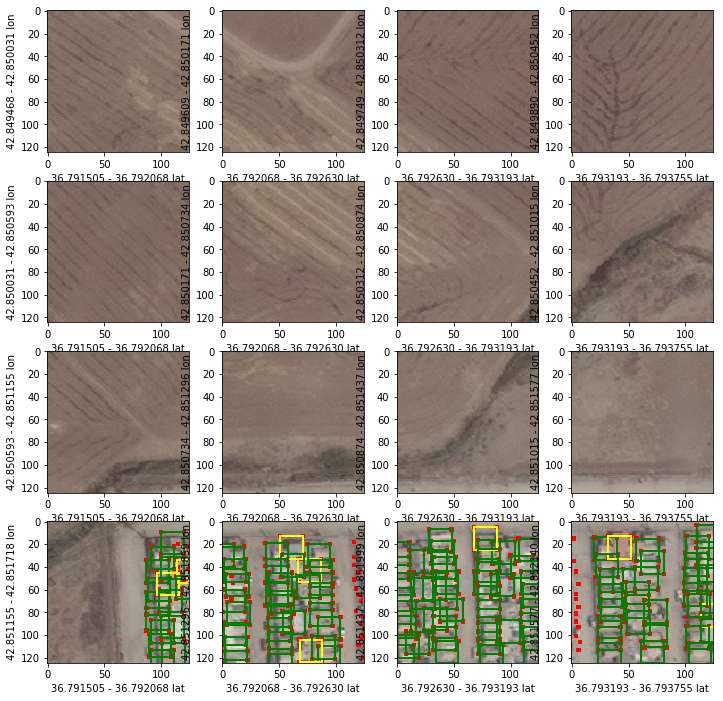

In [0]:
idx = 6
r = create_tf_record('%s/%s/%s.png' % (DIRECTORY, REGION, train_crops[idx]), df[df.crop_id == train_crops[idx]], bbox_size=20, shard_sz=125, show=True)

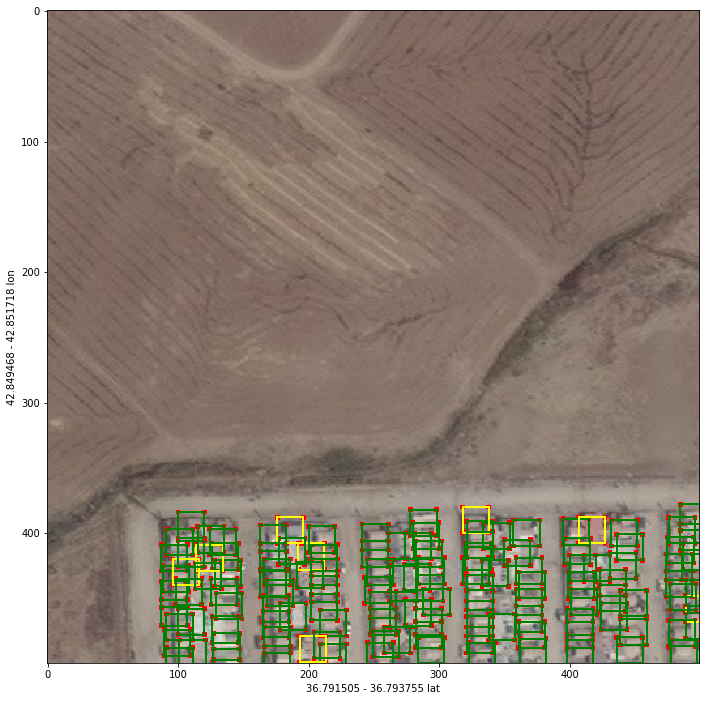

In [0]:
# Print out random example from each camp in the training data set along with
# the original chip_urls for images centered on rater labels
for camp_id in camps_train[:1]:
  if camp_id not in list(df.catalog_id):
    print("Missing camp with id ", camp_id)
    continue
  random_crop = train_crops[idx]
  tfr = create_tf_record('%s/%s/%s.png' % (DIRECTORY, REGION, random_crop),
                         df[df.crop_id == random_crop], bbox_size=20, show=True)

In [0]:
create_tf_record_set('train', train_crops, df, REGION, bbox_size=20,  shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100_label/WesternAsia/train.tfrecord
Completed 0 / 169 in train set
Completed 100 / 169 in train set


In [0]:
create_tf_record_set('val', val_crops, df, REGION, bbox_size=20, shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100_label/WesternAsia/val.tfrecord
Completed 0 / 35 in val set


In [0]:
create_tf_record_set('test', test_crops, df, REGION, bbox_size=20,  shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100_label/WesternAsia/test.tfrecord
Completed 0 / 31 in test set
Could not complete example for crop id 10400100300C7B00_R2C4_166, continuing...


## Africa1

In [0]:
REGION = 'Africa1'

In [0]:
# Read CSV file which is concatenated version of all CSVs
df = pd.read_csv('%s/%s/index.csv' % (DIRECTORY, REGION))
df = df[df.crop_id != 'index'].reset_index(drop=True) # Remove all crop ids == 'index' byproduct of last process
df = df[~df.crop_id.str.contains('BROWSE')].reset_index(drop=True) # Remove all BROWSE images (duplicates)

In [0]:
# Print out number and camps of missing crop ids (compared to the original label)
processed_ids = set(df['id'])
label_ids = set(qc[qc.region == REGION]['id'])
print("Missing %d out of %d ids" % (len(label_ids)-len(processed_ids), len(label_ids)))
missing_ids = [i for i in label_ids if i not in processed_ids]
camp_counter = dict(Counter(qc[qc.id.isin(missing_ids)]['catalog_id']))
camp_counter

Missing 11899 out of 95219 ids


{'1020010064DA6100': 1,
 '103001003E69FD00': 3141,
 '1030010065037C00': 286,
 '103001006BCC1100': 2,
 '1030010076C31300': 1,
 '1030010077970800': 2709,
 '1030011043CB2700': 2128,
 '1040010020BF0D00': 70,
 '105001000589DA00': 115,
 '105001000AABBF00': 1071,
 '105001000AB72000': 2799}

In [0]:
# Get random split of train/validation/test based on fractions defined above
camps = pd.unique(df.catalog_id)
camp_counts = dict(Counter(df.catalog_id))
# camps_test = stratified_random_sample(camps, 0.15, 0.05, camp_counts)
camps_test = ['10400100275B8600', '10300100621D0500', '105001000589DA00', '1050010008D56300']
# camps_val = stratified_random_sample([x for x in camps if x not in camps_test], 0.15, 0.05, camp_counts)
camps_val = ['1030010050D48B00', '1040010020BF0D00', '10200100411F7400', '103001005C8EF000', '1030010058C12400', '1030010076A66E00']
# camps_train = [x for x in camps if x not in camps_test and x not in camps_val]
camps_train = ['10200100058D0600', '1020010064DA6100', '102001006DDDE900', '10300100591ED300', '102001006EBB3100', '10300100615D8600', '1050010009046500', '1030010063456500', '1030010061C87300', '1040010036653200', '1040010028685400', '1040010038907C00', '1030010063D19E00', '103001006BCC1100', '103001006BD75100', '103001006EB13800', '1040010029149500', '1030010076C31300', '103001007A4F7300', '104001002C746300', '104001002DB04400', '104001003712E900', '10500100010CBD00']

In [0]:
# Find all crop ids in each data set
train_crops = pd.unique(df[df.catalog_id.isin(camps_train)]['crop_id'])
val_crops = pd.unique(df[df.catalog_id.isin(camps_val)]['crop_id'])
test_crops = pd.unique(df[df.catalog_id.isin(camps_test)]['crop_id'])
print("Train crops: %d\nVal crops: %d\nTest crops: %d" % (len(train_crops), len(val_crops), len(test_crops)))

Train crops: 5153
Val crops: 974
Test crops: 1054


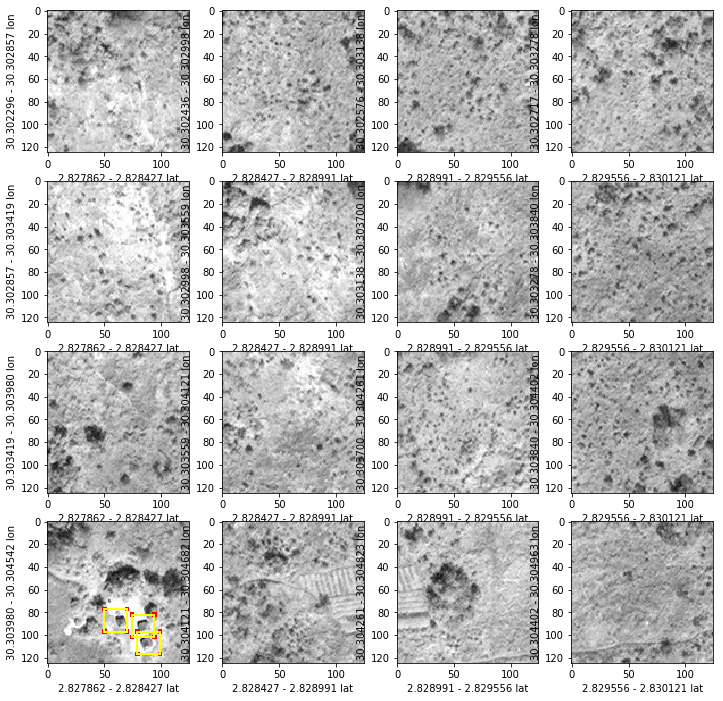

In [0]:
idx = 6
_ = create_tf_record('%s/%s/%s.png' % (DIRECTORY, REGION, train_crops[idx]), df[df.crop_id == train_crops[idx]], bbox_size=20, shard_sz=125, show=True)

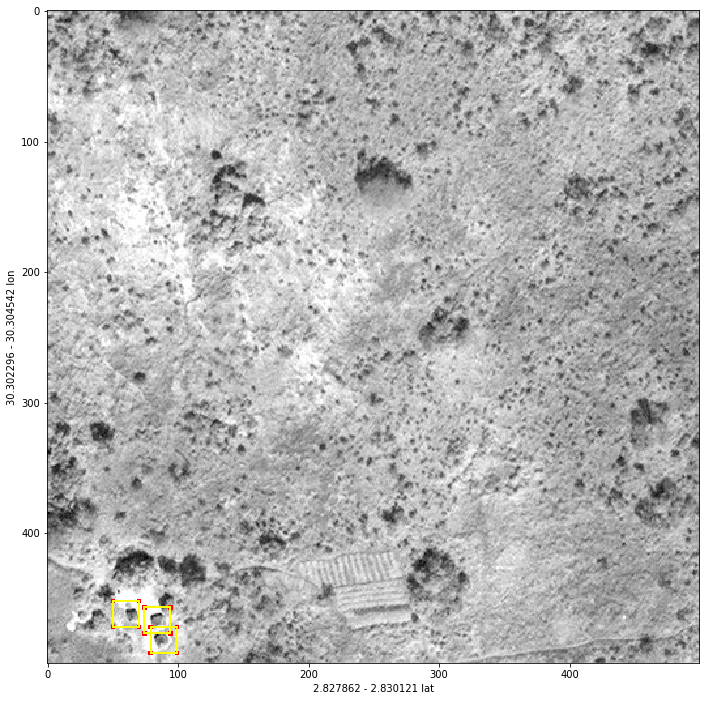

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [0]:
create_tf_record('%s/%s/%s.png' % (DIRECTORY, REGION, train_crops[idx]),
                 df[df.crop_id == train_crops[idx]], bbox_size=20, show=True)

In [0]:
create_tf_record_set('train', train_crops, df, REGION, bbox_size=20, shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100_label/Africa1/train.tfrecord
Completed 0 / 5153 in train set
Completed 100 / 5153 in train set
Completed 200 / 5153 in train set
Completed 300 / 5153 in train set
Completed 400 / 5153 in train set
Could not complete example for crop id 1030010061C87300_R3C3_726, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_727, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_728, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_729, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_730, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_731, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_732, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_733, continuing...
Could not complete example for crop id 1030010061C87300_R3C3_734, continuing...
Could not complete example for crop id 1030

In [0]:
create_tf_record_set('val', val_crops, df, REGION, bbox_size=20, shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100_label/Africa1/val.tfrecord
Completed 0 / 974 in val set
Could not complete example for crop id 10200100411F7400_R12C1_1077, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_1022, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_1055, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_164, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_197, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_230, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_263, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_296, continuing...
Completed 100 / 974 in val set
Could not complete example for crop id 1030010076A66E00_R1C1_329, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_362, continuing...
Could not complete example for crop id 1030010076A66E00_R1C1_395, con

In [0]:
create_tf_record_set('test', test_crops, df, REGION, bbox_size=20, shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100_label/Africa1/test.tfrecord
Completed 0 / 1054 in test set
Completed 100 / 1054 in test set
Completed 200 / 1054 in test set
Completed 300 / 1054 in test set
Completed 400 / 1054 in test set
Completed 500 / 1054 in test set
Completed 600 / 1054 in test set
Completed 700 / 1054 in test set
Completed 800 / 1054 in test set
Completed 900 / 1054 in test set
Completed 1000 / 1054 in test set


## Africa 2

In [0]:
REGION = 'Africa2'

In [0]:
# Read CSV file which is concatenated version of all CSVs
df = pd.read_csv('%s/%s/index.csv' % (DIRECTORY, REGION))
df = df[df.crop_id != 'index'].reset_index(drop=True) # Remove all crop ids == 'index' byproduct of last process
df = df[~df.crop_id.str.contains('BROWSE')].reset_index(drop=True) # Remove all BROWSE images (duplicates)

In [0]:
# Print out number and camps of missing crop ids (compared to the original label)
processed_ids = set(df['id'])
label_ids = set(qc[qc.region == REGION]['id'])
print("Missing %d out of %d ids" % (len(label_ids)-len(processed_ids), len(label_ids)))
missing_ids = [i for i in label_ids if i not in processed_ids]
camp_counter = dict(Counter(qc[qc.id.isin(missing_ids)]['catalog_id']))
camp_counter

Missing 16325 out of 60670 ids


{'102001005A3EB100': 142,
 '102001005B130100': 50,
 '102001006FE72F00': 10,
 '103001003B9BA400': 1188,
 '103001003C44FD00': 383,
 '1030010058ADE100': 31,
 '1030010061C87300': 133,
 '1030010063456500': 3,
 '103001006581DE00': 22,
 '103001007796AD00': 1181,
 '1030010079032E00': 432,
 '10400100184F8E00': 438,
 '104001001936EA00': 3406,
 '104001001A2D7200': 128,
 '104001002278A900': 266,
 '1040010030A72600': 22,
 '104001003A22DB00': 489,
 '1050010002D1B200': 34,
 '1050010003366400': 3304,
 '1050010004212900': 812,
 '1050410010A55A00': 3851}

In [0]:
# Get random split of train/validation/test based on fractions defined above
# camps = pd.unique(df.catalog_id)
# camp_counts = dict(Counter(df.catalog_id))
# camps_test = stratified_random_sample(camps, 0.15, 0.05, camp_counts)
camps_test = ['1040010016921900', '1030010076020C00', '103001006758EF00', '103001005D6C6300', '103001003D767800', '1030010058ADE100']
# camps_val = stratified_random_sample([x for x in camps if x not in camps_test], 0.15, 0.05, camp_counts)
camps_val = ['1040010039837F00', '102001006A540000', '103001005D571800', '1040010030A72600', '102001005B130100']
# camps_train = [x for x in camps if x not in camps_test and x not in camps_val]
camps_train = ['102001005090C800', '102001006D587200', '102001005D904700', '1030010061790600', '1030010061C87300', '1030010063456500', '10300100640BE900', '103001006581DE00', '1030010068742100', '10400100088DB800', '1040010024BE2300', '10500100065B4400', '102001006FE72F00', '1050010009D1DC00', '105001000D37CB00']

In [0]:
# Find all crop ids in each data set
train_crops = pd.unique(df[df.catalog_id.isin(camps_train)]['crop_id'])
val_crops = pd.unique(df[df.catalog_id.isin(camps_val)]['crop_id'])
test_crops = pd.unique(df[df.catalog_id.isin(camps_test)]['crop_id'])
print("Train crops: %d\nVal crops: %d\nTest crops: %d" % (len(train_crops), len(val_crops), len(test_crops)))

Train crops: 3426
Val crops: 787
Test crops: 874


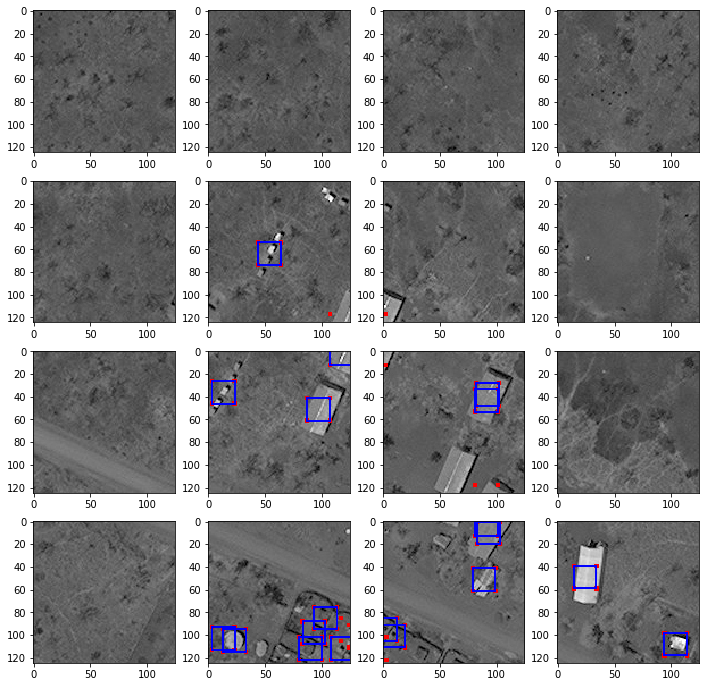

In [0]:
idx = 6
_ = create_tf_record('%s/%s/%s.png' % (DIRECTORY, REGION, train_crops[idx]),
                     df[df.crop_id == train_crops[idx]],
                     bbox_size=20, shard_sz=125, show=True)

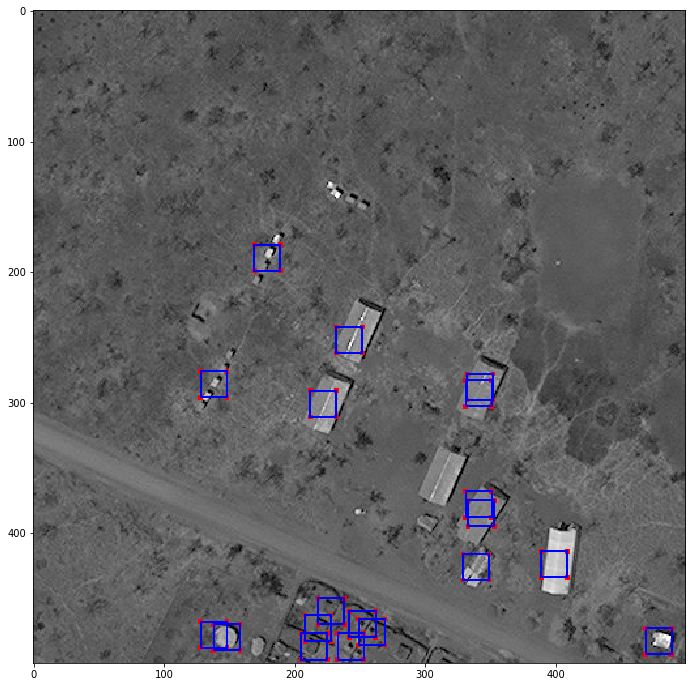

In [0]:
_ = create_tf_record('%s/%s/%s.png' % (DIRECTORY, REGION, train_crops[idx]),
                     df[df.crop_id == train_crops[idx]],
                     bbox_size=20, show=True)

In [0]:
# !cd satellite/tf_records_100 && mkdir Africa2
create_tf_record_set('train', train_crops, df, REGION, bbox_size=20, shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100/Africa2/train.tfrecord
Completed 0 / 3426 in train set
Completed 100 / 3426 in train set
Completed 200 / 3426 in train set
Completed 300 / 3426 in train set
Completed 400 / 3426 in train set
Completed 500 / 3426 in train set
Completed 600 / 3426 in train set
Completed 700 / 3426 in train set
Completed 800 / 3426 in train set
Completed 900 / 3426 in train set
Completed 1000 / 3426 in train set
Completed 1100 / 3426 in train set
Completed 1200 / 3426 in train set
Completed 1300 / 3426 in train set
Completed 1400 / 3426 in train set
Completed 1500 / 3426 in train set
Completed 1600 / 3426 in train set
Completed 1700 / 3426 in train set
Completed 1800 / 3426 in train set
Completed 1900 / 3426 in train set
Completed 2000 / 3426 in train set
Completed 2100 / 3426 in train set
Completed 2200 / 3426 in train set
Completed 2300 / 3426 in train set
Completed 2400 / 3426 in train set
Completed 2500 / 3426 in train set
Completed 2600 / 3426 in train set
Comp

In [0]:
create_tf_record_set('val', val_crops, df, REGION, bbox_size=20, shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100/Africa2/val.tfrecord
Completed 0 / 787 in val set
Completed 100 / 787 in val set
Completed 200 / 787 in val set
Completed 300 / 787 in val set
Completed 400 / 787 in val set
Completed 500 / 787 in val set
Completed 600 / 787 in val set
Completed 700 / 787 in val set


In [0]:
create_tf_record_set('test', test_crops, df, REGION, bbox_size=20, shard_sz=100, output_dir=OUTPUT_DIR)

Outputting to  satellite/tf_records_100/Africa2/test.tfrecord
Completed 0 / 874 in test set
Completed 100 / 874 in test set
Completed 200 / 874 in test set
Completed 300 / 874 in test set
Completed 400 / 874 in test set
Completed 500 / 874 in test set
Completed 600 / 874 in test set
Completed 700 / 874 in test set
Completed 800 / 874 in test set
